In [1]:
import networkx as nx
import numpy as np
import pandas as pd

# for the explode statement; convert string to list
from ast import literal_eval

# for visualization
from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 

# for bipartite projection
from networkx.algorithms import bipartite

# for text and NER
from tqdm import tqdm
import spacy
import requests

nlp = spacy.load("en_core_web_md")

In [2]:
def get_data(): 

    url = 'https://www.gutenberg.org/files/11/11-0.txt' 
    text = requests.get(url).text 

    # strip header junk 
    cutoff = text.index('Alice was beginning') 
    text = text[cutoff:] 

    # strip footer junk 
    cutoff = text.rindex('THE END') 
    text = text[:cutoff] 

    # pre-processing to clean the text 
    text = text.replace('\r', ' ').replace('\n', ' ') 
    text = text.replace('â\x80\x99', '\'').replace('â\x80\x9c', '"').replace('â\x80\x9d', '""').replace('â\x80\x94', ' ') 

    return text

In [3]:
def extract_entities(text): 

    doc = nlp(text) 

    sentences = list(doc.sents) 

    entities = [] 

    for sentence in tqdm(sentences): 

        sentence_entities = [] 

        sent_doc = nlp(sentence.text) 

        for ent in sent_doc.ents: 

            if ent.label_ in ['PERSON', 'ORG', 'GPE']: 

                entity = ent.text.strip() 

                if "'s" in entity: 

                    cutoff = entity.index("'s") 

                    entity = entity[:cutoff] 

                if entity != '': 

                    sentence_entities.append(entity)   

        sentence_entities = list(set(sentence_entities))       

        if len(sentence_entities) > 0: # changed from 1 to zero to grab individuals from sentences; new idea after book

            entities.append(sentence_entities) 

    return entities 

In [4]:
def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5): 

    adjacency = nx.to_scipy_sparse_matrix(G, nodelist=None, dtype=None, weight='weight', format='csr') 

    names = np.array(list(G.nodes())) 

    graph = Bunch() 
    graph.adjacency = adjacency 
    graph.names = np.array(names) 

    pagerank = PageRank() 

    scores = pagerank.fit_transform(adjacency) 

    if show_names: 
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width) 

    else: 

        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width) 

    return SVG(image) 

# Get Text

In [5]:
text = get_data()
text[0:200]

'Alice was beginning to get very tired of sitting by her sister on the  bank, and of having nothing to do: once or twice she had peeped into  the book her sister was reading, but it had no pictures or '

# Extract Entities by Sentence

In [6]:
def drop_duplicate_entities(entities):

    keep_entities = []

    for entity_list in entities:

        if entity_list not in keep_entities:
            keep_entities.append(entity_list)

    return keep_entities

In [7]:
entities = extract_entities(text)
entities = drop_duplicate_entities(entities)
entities[0:5]

100%|██████████████████████████████████████████████████████████████████████████████| 2080/2080 [00:49<00:00, 41.99it/s]


[['Alice'],
 ['Rabbit', 'Alice'],
 ['Longitude', 'Alice'],
 ['Antipathies'],
 ["Ma'am", 'Australia', 'New Zealand']]

In [8]:
entity_df = pd.DataFrame({'entities':entities}).reset_index()
entity_df.columns = ['sentence', 'entity']
entity_df = entity_df.explode('entity')

entity_df = entity_df[['entity', 'sentence']]

# wrangling
entity_df = entity_df[entity_df['entity'].str.contains('CHAPTER', case=False)==False] # drop chapter nodes

entity_df.head()

,entity,sentence
0,Alice,0
1,Rabbit,1
1,Alice,1
2,Longitude,2
2,Alice,2


# Graph Approach: Bipartite Projection (New Idea)

In [9]:
B = nx.from_pandas_edgelist(entity_df, source='entity', target='sentence') # new approach
G = bipartite.projected_graph(B, entity_df['entity'])

# wrangling
G = nx.k_core(G, 1) # quickly remove disconnected junk nodes

drop_nodes = ['Beautiful', 'Hm', 'Improve', 'Longitude', 'Ma\'am', 'Mystery', 'Said', 'Seaography', 'Somebody', 
              'The Rabbit Sends', 'garden_.', 'The Rabbit Sends', 'the White Rabbit', "â\x80\x98I'll", 'â\x80\x98Keep', 
              'â\x80\x98it', 'William_']

G.remove_nodes_from(drop_nodes) # remove drop nodes

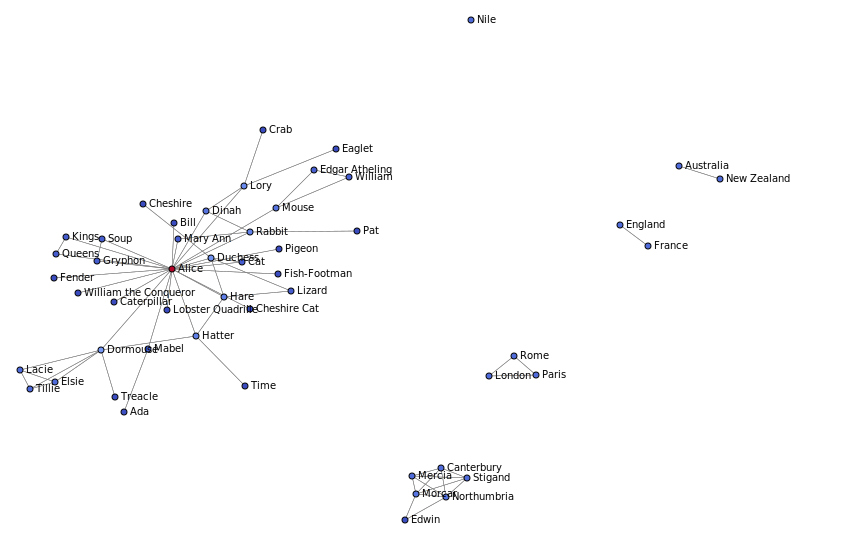

In [10]:
draw_graph(G, show_names=True, node_size=3)

In [11]:
# use this to look through nodes, twenty at a time; change indexes to look around; learn pandas indexing
# useful for identifying junk nodes to remove

sorted(G.nodes)[0:20]

['Ada',
 'Alice',
 'Australia',
 'Bill',
 'Canterbury',
 'Cat',
 'Caterpillar',
 'Cheshire',
 'Cheshire Cat',
 'Crab',
 'Dinah',
 'Dormouse',
 'Duchess',
 'Eaglet',
 'Edgar Atheling',
 'Edwin',
 'Elsie',
 'England',
 'Fender',
 'Fish-Footman']

# New Approach #2, But Inspecting Sentences

This isn't meant to be immediately useful. I am just curious to see if I can see what parts of the network are active based on the sentence number of the sentence that entities were extracted from. If so, that seems like it could be useful, somehow, someday, with more thought.

It's neat that there is a core to this and that the network has been projected differently.

In [15]:
B = nx.from_pandas_edgelist(entity_df, source='entity', target='sentence') # new approach
G_sent = bipartite.projected_graph(B, entity_df['sentence'])

# wrangling
G_sent = nx.k_core(G_sent, 1) # quickly remove disconnected junk nodes

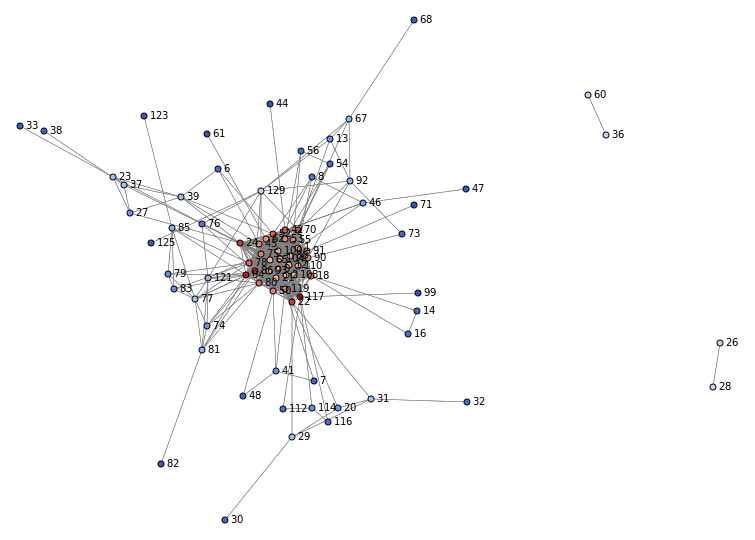

In [16]:
draw_graph(G_sent, show_names=True, node_size=3)

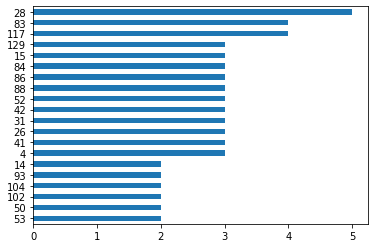

In [22]:
entity_df['sentence'].value_counts()[0:20].plot.barh().invert_yaxis()

In [30]:
def fetch_entities_by_sentence(entity_df, sentence):

    return sorted(entity_df[entity_df['sentence']==sentence]['entity'].values)

In [31]:
fetch_entities_by_sentence(entity_df, 28)

['Canterbury', 'Mercia', 'Morcar', 'Northumbria', 'Stigand']

In [32]:
fetch_entities_by_sentence(entity_df, 83)

['Dormouse', 'Elsie', 'Lacie', 'Tillie']

In [33]:
fetch_entities_by_sentence(entity_df, 117)

['Alice', 'Beautiful', 'Gryphon', 'Soup']

In [34]:
fetch_entities_by_sentence(entity_df, 129)

['Duchess', 'Hare', 'Lizard']

At the very least, I can see what sentences have the most activity, and sentences can be investigated, this way. Another fusion of NLP and Networks.

# Egocentric Network Analysis

As the above visualization shows, this is a complex network. For knowledge discovery, we should use Egocentric Network Analysis to "zoom in" on nodes of interest. Any node can be looked at, but I am going to programmatically do this, in this notebook, showing only the top twenty nodes, according to page rank.

In [36]:
page_rank = nx.pagerank(G)

pr_df = pd.DataFrame().from_dict(page_rank, orient='index')
pr_df.columns = ['page_rank']
pr_df.sort_values('page_rank', ascending=False, inplace=True)
pr_df.head(10)

,page_rank
Alice,0.157058
Dormouse,0.038245
Duchess,0.034317
Lory,0.031326
Rabbit,0.029086
Hatter,0.027345
Hare,0.026592
Northumbria,0.024562
Morcar,0.024562
Mouse,0.022743


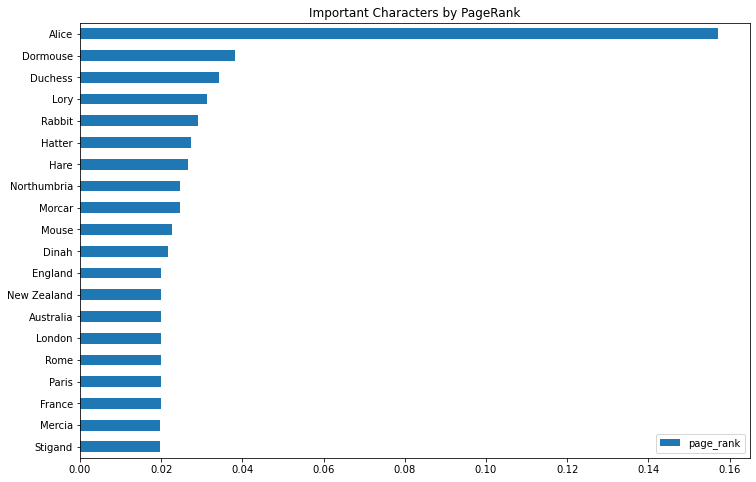

In [37]:
title = 'Important Characters by PageRank'

pr_df.head(20).plot.barh(figsize=(12,8), title=title).invert_yaxis()

# Egocentric Network Analysis
Next, let's look at the Ego Graphs for each of the top ten characters found by PageRank. Before visualizing and inspecting the Ego Graphs, let's create a Python list so that we can more easily look through them without explicitely typing their names.

In [39]:
top_nodes = pr_df.head(20).index.values

In [40]:
top_nodes[0]

'Alice'

Now we are all set to start looking through them, in order of importance.

## Top Node Ego Networks
Unlike last time, I am not going to drop the center node or write about findings. This is purely discovery. Remember two things:
- The center node is known as the 'ego' node. It is the node being looked up.
- The other nodes are known as 'alter' nodes. They are connected to the ego node, and sometimes with each other.

Pay close attention to the alter nodes that link to other alter nodes. These are interesting relationships, and you can see subcommunities in the ego network. Think about what you are seeing. What does this tell you?

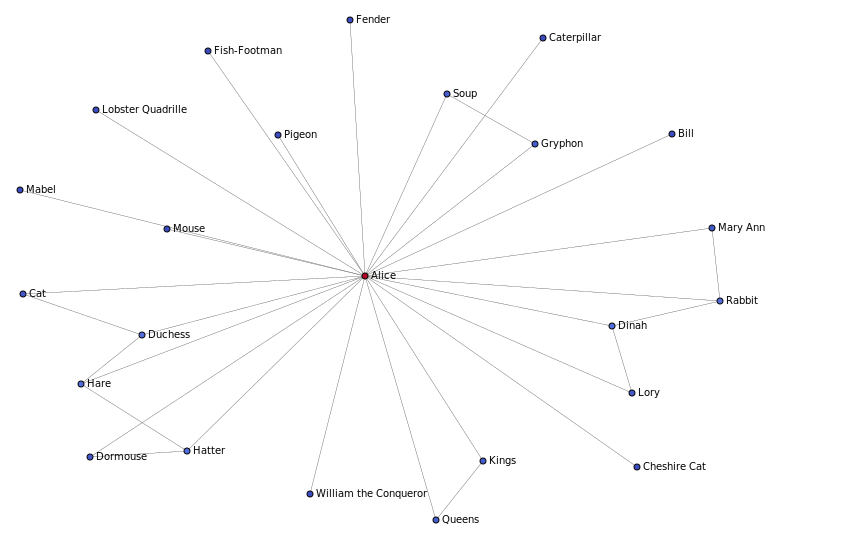

In [69]:
ego = top_nodes[0]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

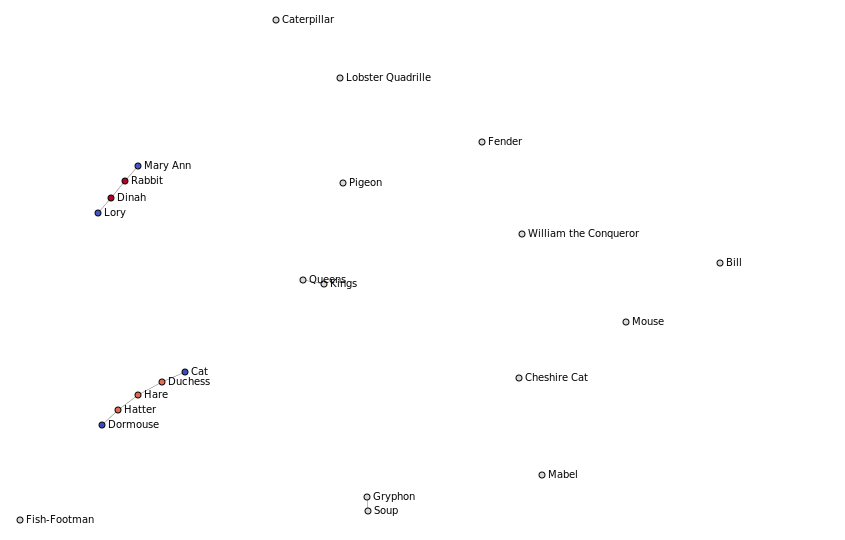

In [43]:
ego = top_nodes[0]

G_ego = nx.ego_graph(G, ego, center=False)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

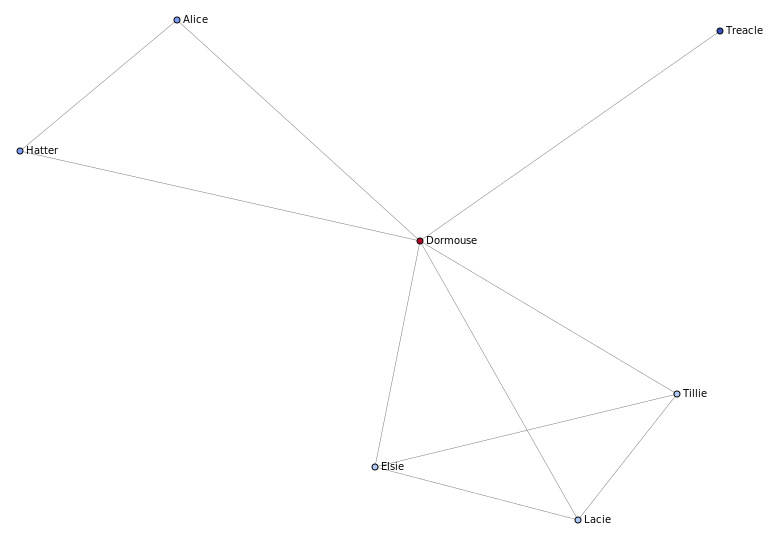

In [44]:
ego = top_nodes[1]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

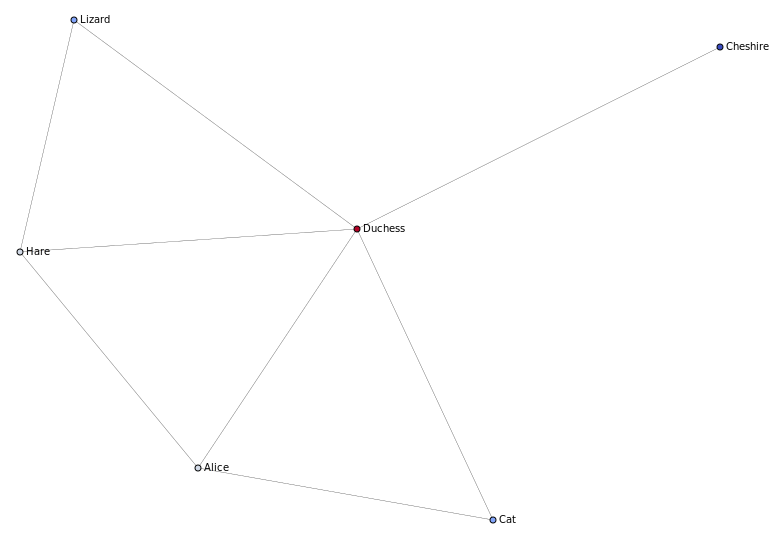

In [45]:
ego = top_nodes[2]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

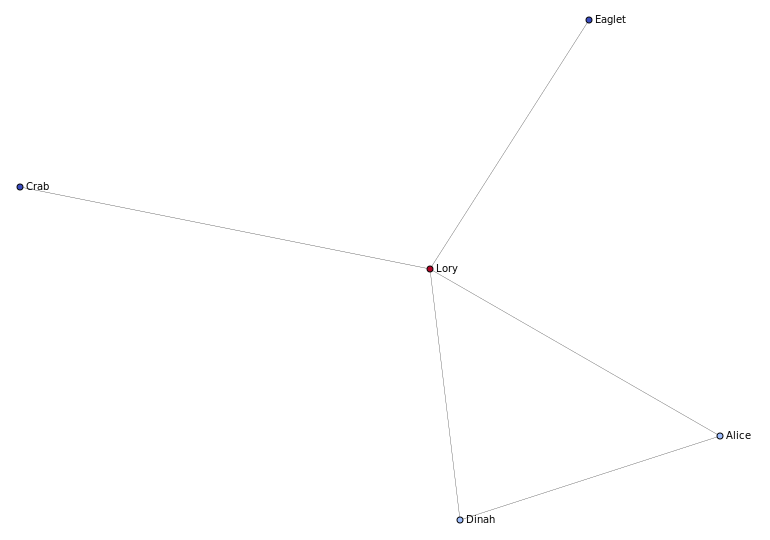

In [46]:
ego = top_nodes[3]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

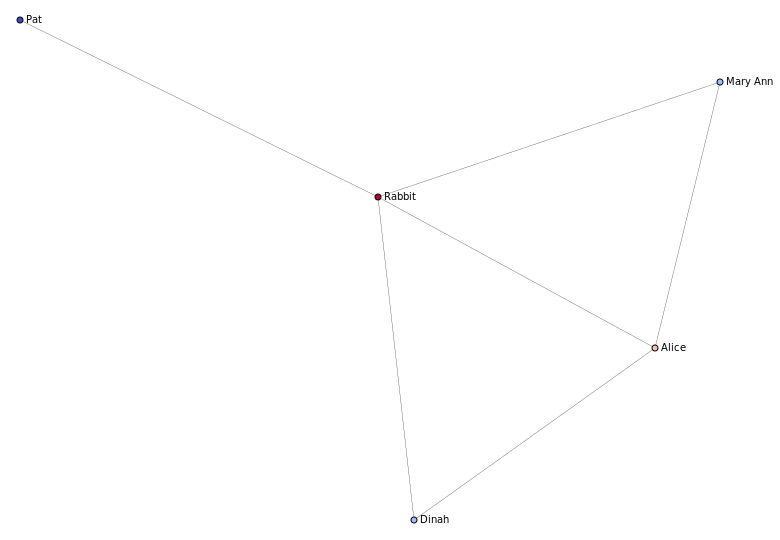

In [47]:
ego = top_nodes[4]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

# Community Detection

We have one large connected component, and this will be great for use in Community Detection. The smaller connected components are communities of their own in this network, split off from the main piece of this network.

In [48]:
def draw_partition(G, partition): 

    import matplotlib.cm as cm 
    import matplotlib.pyplot as plt 

    # draw the graph 
    plt.figure(3,figsize=(12,12)) 
    pos = nx.spring_layout(G) 

    # color the nodes according to their partition 
    cmap = cm.get_cmap('jet', max(partition.values()) + 1) 
    nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values())) 
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=0.3) 

    return plt.show() 

In [59]:
# identify communities; set resolution to 0.01 for smaller groups and 1 for larger groups, etc
# play with the number to get communities to the size you want them, or leave it at the default

import community as community_louvain

partition = community_louvain.best_partition(G, resolution=10, random_state=1337) # 10 was good for this network

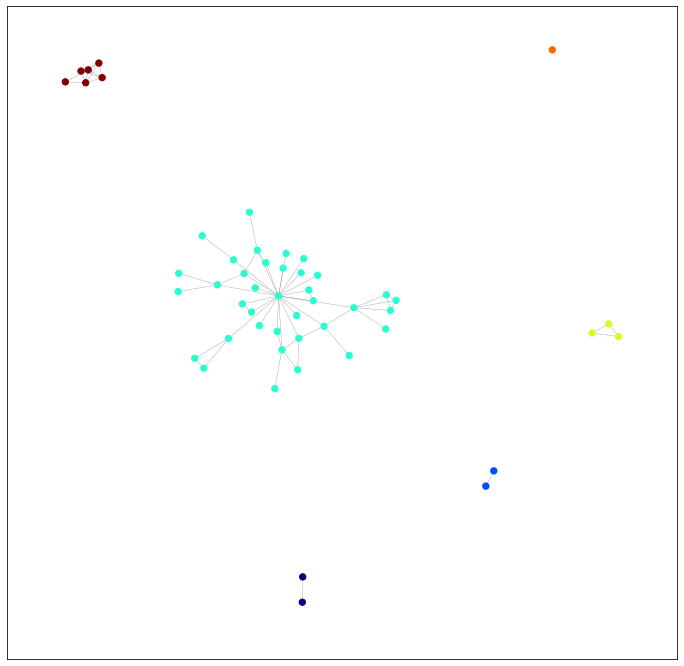

In [60]:
draw_partition(G, partition)

In [61]:
community_df = pd.DataFrame().from_dict(partition, orient='index')
community_df.reset_index(inplace=True)
community_df.columns = ['node', 'community']

# remove junk; identify relevant communities

community_df['community'].value_counts()[0:20]

2    37
5     6
3     3
1     2
0     2
4     1
Name: community, dtype: int64

In [62]:
comm_idx = community_df['community'].value_counts()[0:20].index.values
comm_idx

array([2, 5, 3, 1, 0, 4], dtype=int64)

## Exploring Communities
Below, I am showing the largest community in the network.

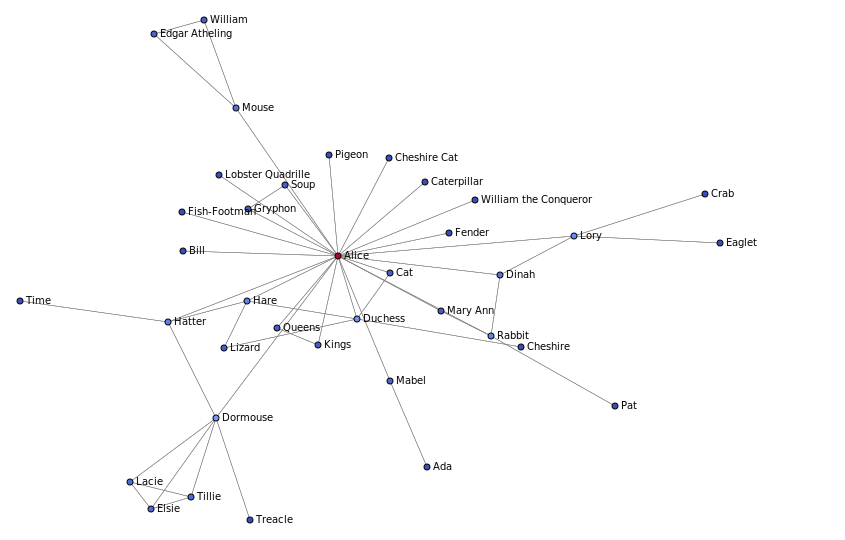

In [63]:
nodes = community_df[community_df['community']==comm_idx[0]]['node'].values

G_comm = G.subgraph(nodes)
G_net_main = G_comm.copy() # we will run community detection off of this at the end

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [64]:
nodes = [n for n in sorted(G_net_main.nodes)]
[print(n) for n in nodes]

Ada
Alice
Bill
Cat
Caterpillar
Cheshire
Cheshire Cat
Crab
Dinah
Dormouse
Duchess
Eaglet
Edgar Atheling
Elsie
Fender
Fish-Footman
Gryphon
Hare
Hatter
Kings
Lacie
Lizard
Lobster Quadrille
Lory
Mabel
Mary Ann
Mouse
Pat
Pigeon
Queens
Rabbit
Soup
Tillie
Time
Treacle
William
William the Conqueror


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## More Communities!

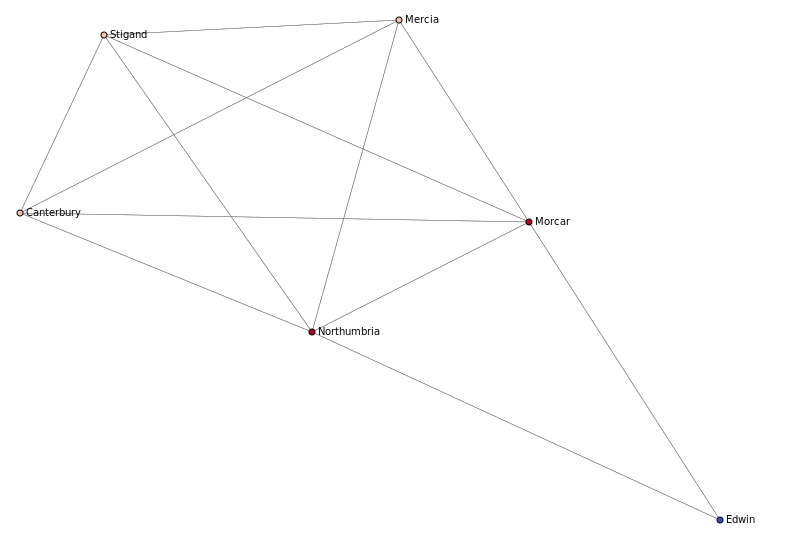

In [65]:
nodes = community_df[community_df['community']==comm_idx[1]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [66]:
[print(n) for n in sorted(G_comm.nodes)]

Canterbury
Edwin
Mercia
Morcar
Northumbria
Stigand


[None, None, None, None, None, None]

# Use Any Text

You can do this with any text whatsoever, whether it be literature, audio transcribed into text, online news, anything. If you have text and spaCy's NER models are able to extract entities, then this will work.

This in no way diminishes the value of text or of reading. It is an additional tool that can be used to understand the relationships that exist in text. It is an additional learning tool, for understanding. It is not a replacement for reading. It can give greater understanding and awareness.

The first time I did this, I used the book of Genesis from the Bible.

NER models will improve over time, and LLMs can extract entities as well. Use whatever you want for the entity extraction, and then use this or a similar approach for wiring the network together.